In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing data
from scipy.io import wavfile
from pydub import AudioSegment
import IPython
import librosa
import IPython.display as ipd
import librosa.display
import parselmouth
import os
import seaborn as sns

### LOADING DATA AND VISUALIZING IT
Load Both Training Data and Test Data From the Given Csv and Visualize it

In [3]:
data = pd.read_csv('truncated_train.csv')
data.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [6]:
print('Shape of Data is: ', data.shape)
null_count = data['age'].isnull().sum()
print("Number of null values in the 'age' column:", null_count)

Shape of Data is:  (15001, 8)
Number of null values in the 'age' column: 9386


In [7]:
# Loading Test Data
test_data = pd.read_csv('cv-valid-test.csv')
test_data.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...,2,0,NaN,NaN,NaN,NaN


In [8]:
print('Shape of Data is: ', test_data.shape)
null_count = test_data['age'].isnull().sum()
print("Number of null values in the 'age' column:", null_count)

Shape of Data is:  (3995, 8)
Number of null values in the 'age' column: 2453


### CLEANING THE DATA
Extracting and Cleaning the columns that are useful and Droping the Rest

In [9]:
data = data[['filename', 'age']]
data = data[data['age'].notna()]
data.reset_index(inplace=True, drop=True)
data.head()

,filename,age
0,cv-valid-train/sample-000005.mp3,twenties
1,cv-valid-train/sample-000008.mp3,seventies
2,cv-valid-train/sample-000013.mp3,thirties
3,cv-valid-train/sample-000014.mp3,sixties
4,cv-valid-train/sample-000019.mp3,fifties


In [10]:
print('Shape of Data is: ', data.shape)
null_count = data['age'].isnull().sum()
print("Number of null values in the 'age' column:", null_count)

Shape of Data is:  (5615, 2)
Number of null values in the 'age' column: 0


In [11]:
test_data = test_data[['filename', 'age']]
test_data = test_data[test_data['age'].notna()]
test_data.reset_index(inplace=True, drop=True)
test_data.head()

,filename,age
0,cv-valid-test/sample-000001.mp3,twenties
1,cv-valid-test/sample-000003.mp3,twenties
2,cv-valid-test/sample-000005.mp3,twenties
3,cv-valid-test/sample-000006.mp3,twenties
4,cv-valid-test/sample-000007.mp3,thirties


In [12]:
print('Shape of Data is: ', test_data.shape)
null_count = test_data['age'].isnull().sum()
print("Number of null values in the 'age' column:", null_count)

Shape of Data is:  (1542, 2)
Number of null values in the 'age' column: 0


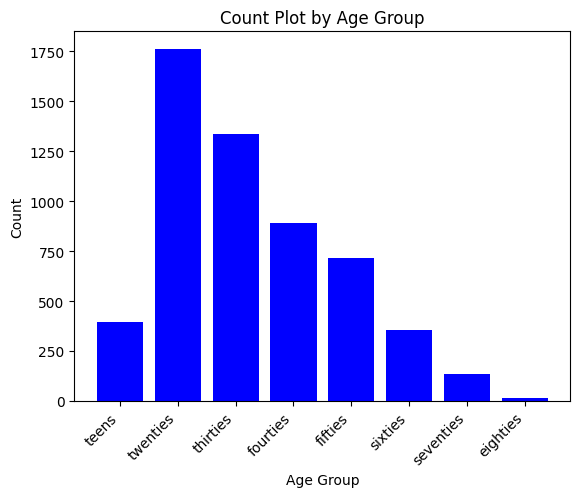

In [13]:
age_order = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties']

plot_data = data['age'].value_counts().reindex(age_order, fill_value=0)
# Create a bar plot
fig, ax = plt.subplots()

# Plotting the data
ax.bar(plot_data.index, plot_data.values, color='blue', align='center')


ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.set_title('Count Plot by Age Group')

ax.set_xticks(range(len(plot_data.index)))
ax.set_xticklabels(plot_data.index, rotation=45, ha='right')

# Show the plot
plt.show()

In [13]:
# Define the mapping from words to numbers
age_map = {
    'teens': 10,
    'twenties': 20,
    'thirties': 30,
    'fourties': 40,
    'fifties': 50,
    'sixties': 60,
    'seventies': 70,
    'eighties': 80,
    'nineties': 90
}

### Extracting Features of Training Audios and Test Audios




In [14]:
# EXTRACTING FREATURE OF TEST_DATA

columns = ['Age', 'Pitch', 'Formant', 'Intensity', 'Duration', 'Spectral Centroid',
           'Spectral Bandwidth', 'Spectral Contrast', 'Spectral Flatness', 'MFCC', 'Chroma', 'Zero Crossing Rate']
test_features = pd.DataFrame(columns=columns)

for index, row in test_data.iterrows():
    filename = row['filename']
    age_word = row['age']
    path = 'cv-valid-test'
    temp = '/'


    # Load audio with librosa
    y, sr = librosa.load(path + temp + filename)
    sound = parselmouth.Sound(path + temp + filename)

    # Calculate features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0])  # ignoring zero values
    intensity = np.mean(librosa.feature.rms(y=y))
    duration = librosa.get_duration(y=y, sr=sr)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)  # Average across time
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    zc_rate = np.mean(librosa.feature.zero_crossing_rate(y))

    # Calculate formant
    formant = sound.to_formant_burg()
    intervals = np.arange(0, sound.duration, 0.01)
    formant_F1 = [formant.get_value_at_time(1, interval) for interval in intervals if not np.isnan(formant.get_value_at_time(1, interval))]
    formant_F1_mean = np.nanmean(formant_F1) if formant_F1 else np.nan  # handle empty list case

    # Prepare new row to append
    new_row = pd.DataFrame({
        'Age': [age_map[age_word]],
        'Pitch': [pitch],
        'Formant': [formant_F1_mean],
        'Intensity': [intensity],
        'Duration': [duration],
        'Spectral Centroid': [centroid],
        'Spectral Bandwidth': [bandwidth],
        'Spectral Contrast': [contrast],
        'Spectral Flatness': [flatness],
        'MFCC': [np.mean(mfcc)],  # Taking mean of means if necessary
        'Chroma': [chroma],
        'Zero Crossing Rate': [zc_rate]
    }, columns=columns)

    # Append new row
    test_features = pd.concat([test_features, new_row], ignore_index=True)

In [15]:
# EXTRACTING FREATURE OF TRAINING DATA

columns = ['Age', 'Pitch', 'Formant', 'Intensity', 'Duration', 'Spectral Centroid',
           'Spectral Bandwidth', 'Spectral Contrast', 'Spectral Flatness', 'MFCC', 'Chroma', 'Zero Crossing Rate']
features = pd.DataFrame(columns=columns)

for index, row in data.iterrows():
    filename = row['filename']
    age_word = row['age']
    path = 'truncated-train'
    temp = '/'

    # Load audio with librosa
    y, sr = librosa.load(path + temp + filename)
    sound = parselmouth.Sound(path + temp + filename)

    # Calculate features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0])  # ignoring zero values
    intensity = np.mean(librosa.feature.rms(y=y))
    duration = librosa.get_duration(y=y, sr=sr)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)  # Average across time
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    zc_rate = np.mean(librosa.feature.zero_crossing_rate(y))

    # Calculate formant
    formant = sound.to_formant_burg()
    intervals = np.arange(0, sound.duration, 0.01)
    formant_F1 = [formant.get_value_at_time(1, interval) for interval in intervals if not np.isnan(formant.get_value_at_time(1, interval))]
    formant_F1_mean = np.nanmean(formant_F1) if formant_F1 else np.nan  # handle empty list case

    # Prepare new row to append
    new_row = pd.DataFrame({
        'Age': [age_map[age_word]],
        'Pitch': [pitch],
        'Formant': [formant_F1_mean],
        'Intensity': [intensity],
        'Duration': [duration],
        'Spectral Centroid': [centroid],
        'Spectral Bandwidth': [bandwidth],
        'Spectral Contrast': [contrast],
        'Spectral Flatness': [flatness],
        'MFCC': [np.mean(mfcc)],  # Taking mean of means if necessary
        'Chroma': [chroma],
        'Zero Crossing Rate': [zc_rate]
    }, columns=columns)

    # Append new row
    features = pd.concat([features, new_row], ignore_index=True)


Saving the Extracted Feature to CSV

In [16]:
# Saving The Features of Both DataFrames into csv
test_features.to_csv('Test_Feature.csv', index=False)
features.to_csv('Features.csv', index=False)

In [17]:
test_features = pd.read_csv('Test_Feature.csv')
test_features.head()

,Age,Pitch,Formant,Intensity,Duration,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,MFCC,Chroma,Zero Crossing Rate
0,20,1603.7770,656.945227,0.039991,1.944036,1955.858160,1995.577027,20.779593,0.063335,-14.599541,0.466889,0.119501
1,20,1245.8246,684.414296,0.009894,7.704036,2308.464665,2282.965698,21.999681,0.065618,-24.553047,0.383677,0.125718
2,20,1149.2809,620.911195,0.045127,4.656009,1966.360052,1835.719970,23.327709,0.020888,-13.521243,0.363066,0.111629
3,20,1919.3458,913.672066,0.005734,4.680000,2991.734249,2504.903685,20.044931,0.091002,-21.191105,0.494481,0.197343
4,30,1582.1821,914.202294,0.031965,2.616009,2628.525092,2539.646682,19.614251,0.074611,-10.293879,0.575692,0.143010


In [18]:
features = pd.read_csv('Features.csv')
features.head()

,Age,Pitch,Formant,Intensity,Duration,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,MFCC,Chroma,Zero Crossing Rate
0,20,1220.57290,592.665139,0.006928,5.832018,1827.311994,1891.320962,23.357881,0.008766,-27.616852,0.344941,0.091979
1,70,1613.80970,740.876205,0.015059,1.728027,2405.960497,1929.718353,22.093263,0.039348,-21.074581,0.390814,0.167148
2,30,1681.96020,775.933068,0.038097,4.224036,1853.162931,1379.076500,25.515921,0.001174,-20.890913,0.314568,0.120190
3,60,794.12585,619.218386,0.032311,5.376009,1844.103885,1897.411956,22.806667,0.022437,-17.845570,0.357120,0.082688
4,50,937.07153,848.577075,0.045045,3.720000,1910.189138,2246.842211,20.065554,0.032897,-3.291733,0.534488,0.081397


### Visualizing the Features of the Training Audios to see Trends

In [19]:
age_group_dfs = {}

# Unique ages in the DataFrame
unique_ages = features['Age']

# # Loop through each unique age and create a separate DataFrame
for age in unique_ages:
    age_group_dfs[age] = features[features['Age'] == age]

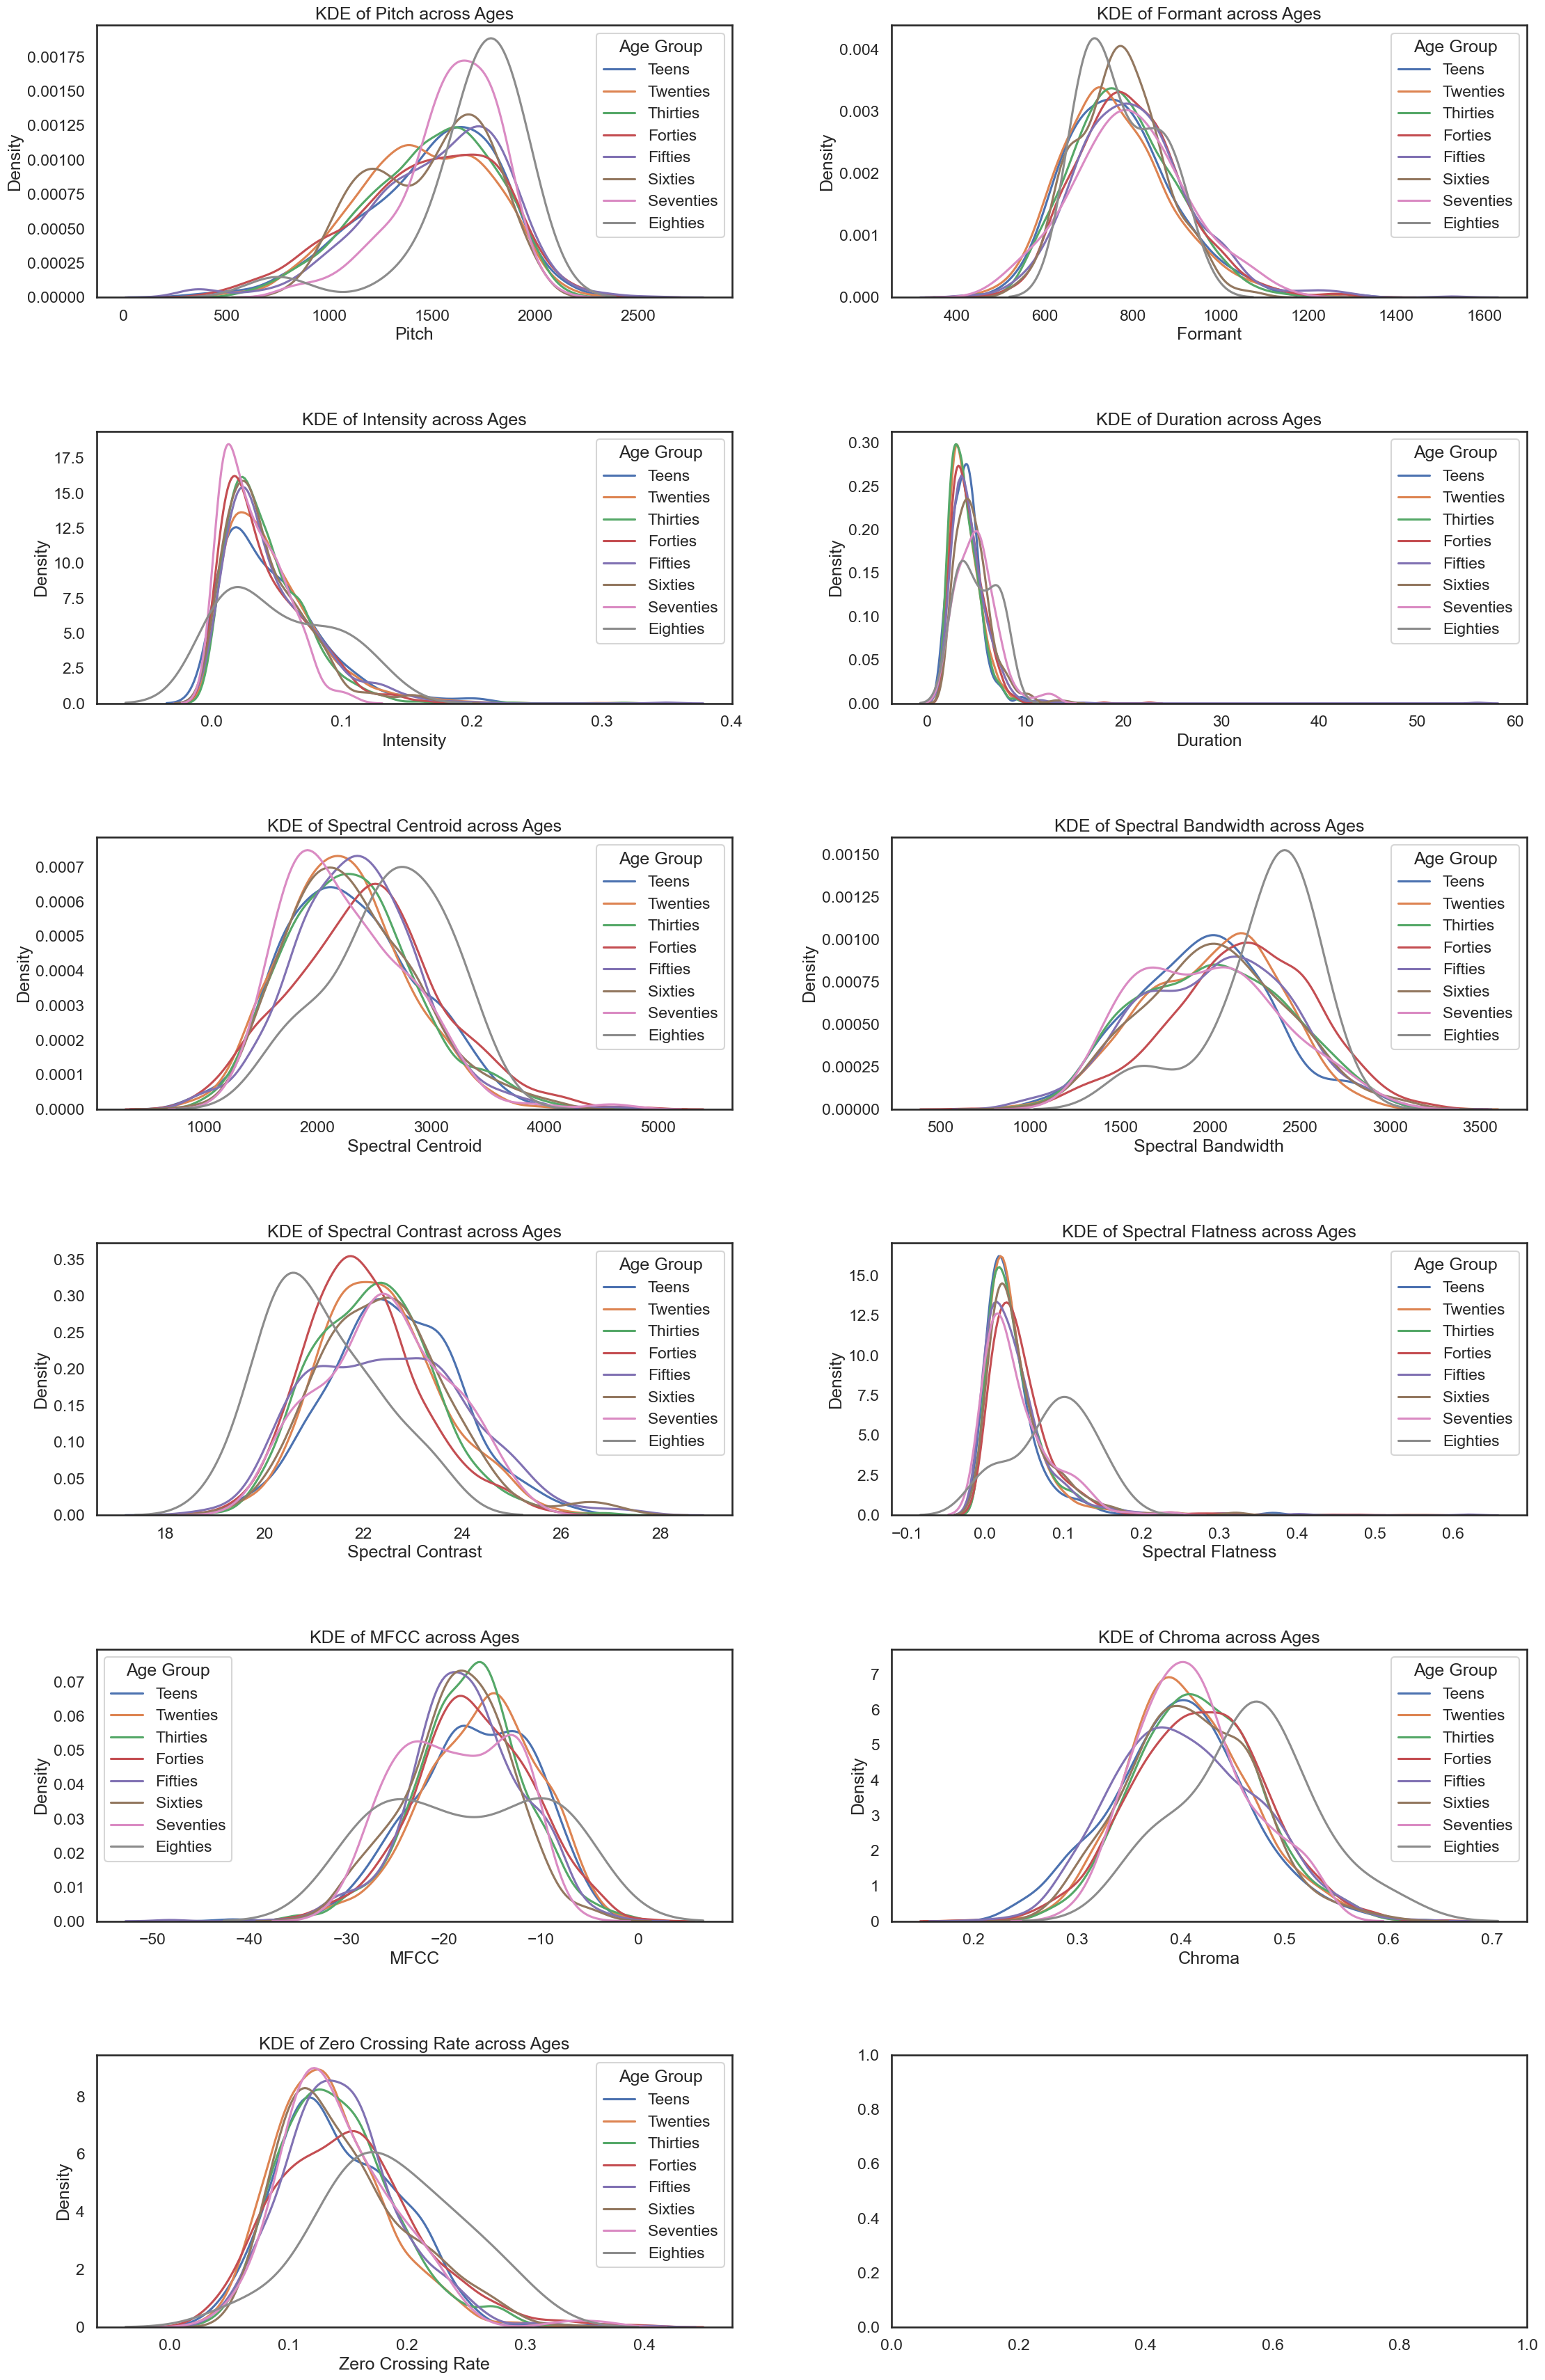

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="white", context="talk")

# Data filtered by age groups
teens_data = features[features['Age'] == 10]
twenty_data = features[features['Age'] == 20]
thirty_data = features[features['Age'] == 30]
fourty_data = features[features['Age'] == 40]
fifty_data = features[features['Age'] == 50]
sixty_data = features[features['Age'] == 60]
seventy_data = features[features['Age'] == 70]
eighty_data = features[features['Age'] == 80]
ninety_data = features[features['Age'] == 90]

# Create a larger figure to accommodate the plots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(24, 36))  # Increased figure size
axes = axes.flatten()  # Flatten the array of axes

# List of features to plot
feature_names = ['Pitch', 'Formant', 'Intensity', 'Duration', 'Spectral Centroid',
                 'Spectral Bandwidth', 'Spectral Contrast', 'Spectral Flatness', 'MFCC', 'Chroma', 'Zero Crossing Rate']

# Plot each feature for all age groups
for i, feature in enumerate(feature_names):
    if i < len(axes):  # Ensure there's an axis for each feature
        sns.kdeplot(data=teens_data, x=feature, ax=axes[i], warn_singular=False, label="Teens")
        sns.kdeplot(data=twenty_data, x=feature, ax=axes[i], warn_singular=False, label="Twenties")
        sns.kdeplot(data=thirty_data, x=feature, ax=axes[i], warn_singular=False, label="Thirties")
        sns.kdeplot(data=fourty_data, x=feature, ax=axes[i], warn_singular=False, label="Forties")
        sns.kdeplot(data=fifty_data, x=feature, ax=axes[i], warn_singular=False, label="Fifties")
        sns.kdeplot(data=sixty_data, x=feature, ax=axes[i], warn_singular=False, label="Sixties")
        sns.kdeplot(data=seventy_data, x=feature, ax=axes[i], warn_singular=False, label="Seventies")
        sns.kdeplot(data=eighty_data, x=feature, ax=axes[i], warn_singular=False, label="Eighties")
        sns.kdeplot(data=ninety_data, x=feature, ax=axes[i], warn_singular=False, label="Nineties")
        axes[i].set_title(f'KDE of {feature} across Ages')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].legend(title='Age Group')

# Adjust layout to prevent overlap
plt.tight_layout(pad=4.0)  # Increased padding for better clarity
plt.show()


### Applying Multi Regression Using All Features

In [21]:
def loss_function(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c, points):
    total_error = 0
    for i in range(len(points)):
        x1 = points.iloc[i]['Pitch']
        x2 = points.iloc[i]['Formant']
        x3 = points.iloc[i]['Intensity']
        x4 = points.iloc[i]['Duration']
        x5 = points.iloc[i]['Spectral Centroid']
        x6 = points.iloc[i]['Spectral Bandwidth']
        x7 = points.iloc[i]['Spectral Contrast']
        x8 = points.iloc[i]['Spectral Flatness']
        x9 = points.iloc[i]['MFCC']
        x10 = points.iloc[i]['Chroma']
        x11 = points.iloc[i]['Zero Crossing Rate']
        y = points.iloc[i]['Age']
        # Update prediction equation to include all features
        prediction = (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4) + (m5 * x5) + (m6 * x6) + (m7 * x7) + (m8 * x8) + (m9 * x9) + (m10 * x10) + (m11 * x11) + c
        total_error += (y - prediction) ** 2
    return total_error / float(len(points))

In [22]:
def gradient_descent(m1_now, m2_now, m3_now, m4_now, m5_now, m6_now, m7_now, m8_now, m9_now, m10_now, m11_now, b_now, points, L):
    # Extracting features and target from the dataframe
    x1 = points['Pitch'].values
    x2 = points['Formant'].values
    x3 = points['Intensity'].values
    x4 = points['Duration'].values
    x5 = points['Spectral Centroid'].values
    x6 = points['Spectral Bandwidth'].values
    x7 = points['Spectral Contrast'].values
    x8 = points['Spectral Flatness'].values
    x9 = points['MFCC'].values
    x10 = points['Chroma'].values
    x11 = points['Zero Crossing Rate'].values
    y = points['Age'].values

    # Number of observations
    n = len(y)

    # Predicted ages
    pred = (m1_now * x1) + (m2_now * x2) + (m3_now * x3) + (m4_now * x4) + \
           (m5_now * x5) + (m6_now * x6) + (m7_now * x7) + (m8_now * x8) + \
           (m9_now * x9) + (m10_now * x10) + (m11_now * x11) + b_now

    # Calculating gradients
    error = y - pred
    m1_gradient = -(2/n) * np.dot(x1, error)
    m2_gradient = -(2/n) * np.dot(x2, error)
    m3_gradient = -(2/n) * np.dot(x3, error)
    m4_gradient = -(2/n) * np.dot(x4, error)
    m5_gradient = -(2/n) * np.dot(x5, error)
    m6_gradient = -(2/n) * np.dot(x6, error)
    m7_gradient = -(2/n) * np.dot(x7, error)
    m8_gradient = -(2/n) * np.dot(x8, error)
    m9_gradient = -(2/n) * np.dot(x9, error)
    m10_gradient = -(2/n) * np.dot(x10, error)
    m11_gradient = -(2/n) * np.dot(x11, error)
    b_gradient = -(2/n) * np.sum(error)

    # Updating parameters
    m1 = m1_now - L * m1_gradient
    m2 = m2_now - L * m2_gradient
    m3 = m3_now - L * m3_gradient
    m4 = m4_now - L * m4_gradient
    m5 = m5_now - L * m5_gradient
    m6 = m6_now - L * m6_gradient
    m7 = m7_now - L * m7_gradient
    m8 = m8_now - L * m8_gradient
    m9 = m9_now - L * m9_gradient
    m10 = m10_now - L * m10_gradient
    m11 = m11_now - L * m11_gradient
    b = b_now - L * b_gradient

    return m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, b

In [23]:
# Initializing coefficients for all 11 features and the intercept
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11 = [0] * 11  # All coefficients initialized to 0
c = 0  # Intercept

# Set the learning rate and number of epochs for gradient descent
lr = 0.00000001
epochs = 1000

for i in range(epochs):
    # Pass and update coefficients and intercept
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c = gradient_descent(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c, features, lr)
    if i % 100 == 0:
        # Calculate error using updated coefficients and intercept
        error = loss_function(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c, features)
        print(f"Epoch {i} - Error: {error}")

# Print the final coefficients and intercept
print(f'M1: {m1}, M2: {m2}, M3: {m3}, M4: {m4}, M5: {m5}, M6: {m6}, M7: {m7}, M8: {m8}, M9: {m9}, M10: {m10}, M11: {m11}, Intercept: {c}')


Epoch 0 - Error: 825.9336628683355
Epoch 100 - Error: 242.0375345076796
Epoch 200 - Error: 238.76300639974613
Epoch 300 - Error: 236.2416165265184
Epoch 400 - Error: 234.28238187657226
Epoch 500 - Error: 232.74818411180928
Epoch 600 - Error: 231.53887319258365
Epoch 700 - Error: 230.58016229389267
Epoch 800 - Error: 229.81620122657887
Epoch 900 - Error: 229.20451682262825
M1: 0.008896968944447674, M2: 0.008161563266115708, M3: 8.268626768103129e-07, M4: 0.00014860528196848462, M5: -0.0026509751930833443, M6: 0.009194260379952373, M7: 0.000377892502125192, M8: -6.297451691563764e-07, M9: -0.0003306613303761959, M10: 4.760348418327363e-06, M11: -2.329353535943157e-07, Intercept: 1.5040047548379654e-05


In [32]:
correct_predictions = 0
for i in range(len(test_features)):
    # Extracting all feature values for each test point
    x1 = test_features.iloc[i]['Pitch']
    x2 = test_features.iloc[i]['Formant']
    x3 = test_features.iloc[i]['Intensity']
    x4 = test_features.iloc[i]['Duration']
    x5 = test_features.iloc[i]['Spectral Centroid']
    x6 = test_features.iloc[i]['Spectral Bandwidth']
    x7 = test_features.iloc[i]['Spectral Contrast']
    x8 = test_features.iloc[i]['Spectral Flatness']
    x9 = test_features.iloc[i]['MFCC']
    x10 = test_features.iloc[i]['Chroma']
    x11 = test_features.iloc[i]['Zero Crossing Rate']

    # Calculate the prediction using all coefficients
    prediction = c + (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4) + (m5 * x5) + (m6 * x6) + (m7 * x7) + (m8 * x8) + (m9 * x9) + (m10 * x10) + (m11 * x11)

    # Rounding the prediction to the nearest age group in tens
    rounded_prediction = 10 * round(prediction / 10)

    # Checking if the rounded prediction matches the actual age
    if rounded_prediction == test_features.iloc[i]['Age']:
        correct_predictions += 1
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction,'    ','Correct Prediction!')
    else:
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction)

Actual Age:  20.0      Predicted Age:  32.80636360483997
Actual Age:  20.0      Predicted Age:  31.558045778200253
Actual Age:  20.0      Predicted Age:  26.972033141428316
Actual Age:  20.0      Predicted Age:  39.648370448387105
Actual Age:  30.0      Predicted Age:  37.93118526534513
Actual Age:  30.0      Predicted Age:  29.212368924390784      Correct Prediction!
Actual Age:  50.0      Predicted Age:  33.84701506615253
Actual Age:  20.0      Predicted Age:  35.6942815410835
Actual Age:  20.0      Predicted Age:  36.237690491061514
Actual Age:  20.0      Predicted Age:  32.39818563269561
Actual Age:  40.0      Predicted Age:  33.627711729445274
Actual Age:  20.0      Predicted Age:  32.208994861820344
Actual Age:  40.0      Predicted Age:  40.00930660503884      Correct Prediction!
Actual Age:  50.0      Predicted Age:  35.22085109110988
Actual Age:  20.0      Predicted Age:  34.78073835869332
Actual Age:  30.0      Predicted Age:  39.522823412703076
Actual Age:  50.0      Predicte

In [33]:
# Calculating the accuracy of the model
accuracy = correct_predictions / len(test_features) * 100
print("Accuracy of the model:", accuracy)

Accuracy of the model: 24.90272373540856


### Training Regression Model According to Top 4 Features Having Strongest Correlation with Age To Get Better Accuracy

In [40]:
# Find Correlation Between Ages and the Features and Selecting the Top 4 Close to Age
features.corr()["Age"]

Age                   1.000000
Pitch                 0.059267
Formant               0.080290
Intensity            -0.060742
Duration              0.156703
Spectral Centroid     0.060529
Spectral Bandwidth    0.055330
Spectral Contrast    -0.017244
Spectral Flatness     0.039316
MFCC                 -0.108835
Chroma                0.034932
Zero Crossing Rate    0.080578
Name: Age, dtype: float64

In [41]:
# Choosing the Features with the Strongest Correlation with Age
data = pd.read_csv("Features.csv")
data.head()

df = data[["Age","Pitch","Formant","Spectral Centroid","Zero Crossing Rate"]]
df.head()

,Age,Pitch,Formant,Spectral Centroid,Zero Crossing Rate
0,20,1220.57290,592.665139,1827.311994,0.091979
1,70,1613.80970,740.876205,2405.960497,0.167148
2,30,1681.96020,775.933068,1853.162931,0.120190
3,60,794.12585,619.218386,1844.103885,0.082688
4,50,937.07153,848.577075,1910.189138,0.081397


In [42]:
def loss_function(m1, m2, m3, m4 , c ,points):
    total_error = 0
    for i in range(len(points)):
        x1 = points.iloc[i]['Pitch']
        x2 = points.iloc[i]['Formant']
        x3 = points.iloc[i]['Spectral Centroid']
        x4 = points.iloc[i]['Zero Crossing Rate']
        y = points.iloc[i]['Age']
        prediction = (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4) + c
        total_error += (y - prediction) ** 2
    return total_error / float(len(points))

In [43]:
def gradient_descent(m1_now, m2_now, m3_now, m4_now, b_now, points, L):
    # Extracting features and target from the dataframe
    x1 = points['Pitch'].values
    x2 = points['Formant'].values
    x3 = points['Spectral Centroid'].values
    x4 = points['Zero Crossing Rate'].values
    y = points['Age'].values

    # Number of observations
    n = len(y)

    # Predicted ages
    pred = (m1_now * x1) + (m2_now * x2) + (m3_now * x3) + (m4_now * x4) + b_now

    # Calculating gradients
    error = y - pred
    m1_gradient = -(2/n) * np.dot(x1, error)
    m2_gradient = -(2/n) * np.dot(x2, error)
    m3_gradient = -(2/n) * np.dot(x3, error)
    m4_gradient = -(2/n) * np.dot(x4, error)
    b_gradient = -(2/n) * np.sum(error)

    # Updating parameters
    m1 = m1_now - L * m1_gradient
    m2 = m2_now - L * m2_gradient
    m3 = m3_now - L * m3_gradient
    m4 = m4_now - L * m4_gradient
    b = b_now - L * b_gradient

    return m1, m2, m3, m4, b

In [50]:
m1 = 0
m2 = 0
m3 = 0
m4 = 0
c = 0

# Set the learning rate and number of epochs for gradient descent
lr = 0.00000001
epochs = 10000

for i in range(epochs):
    m1, m2,m3,m4, c = gradient_descent(m1 ,m2 ,m3 ,m4 ,c ,df ,lr)
    if i % 1000 == 0:
        error = loss_function(m1, m2,m3,m4, c, df)
        print("Epoch {0} - Error: {1}".format(i, error))
print()
print('M1: ',m1,'M2: ',m2,'M3: ',m3,'M4:',m4,'C:',c)

Epoch 0 - Error: 966.7983306247903
Epoch 1000 - Error: 241.56321016951958
Epoch 2000 - Error: 238.4921785876876
Epoch 3000 - Error: 236.9614985925986
Epoch 4000 - Error: 236.1614530730224
Epoch 5000 - Error: 235.74234825119268
Epoch 6000 - Error: 235.52277421246728
Epoch 7000 - Error: 235.40773341575556
Epoch 8000 - Error: 235.34745762788023
Epoch 9000 - Error: 235.31587326368984

M1:  0.003971320678128224 M2:  0.029039633251021893 M3:  0.0015428059244575795 M4: -6.163958588487395e-06 C: 0.00013838815887085812


In [51]:
correct_predictions = 0
for i in range(len(test_features)):
    x1 = test_features.iloc[i]['Pitch']
    x2 = test_features.iloc[i]['Formant']
    x3 = test_features.iloc[i]['Intensity']
    x4 = test_features.iloc[i]['Duration']

    prediction = c + (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4)
    rounded_prediction = 10 * (prediction // 10)
    if rounded_prediction == test_features.iloc[i]['Age']:
        correct_predictions += 1
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction,'    ','Correct Prediction!')
    else:
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction)

Actual Age:  20.0      Predicted Age:  25.44674932596183      Correct Prediction!
Actual Age:  20.0      Predicted Age:  24.8228152940608      Correct Prediction!
Actual Age:  20.0      Predicted Age:  22.595375707273668      Correct Prediction!
Actual Age:  20.0      Predicted Age:  34.155157762770386
Actual Age:  30.0      Predicted Age:  32.83162340269315      Correct Prediction!
Actual Age:  30.0      Predicted Age:  26.87143971486741
Actual Age:  50.0      Predicted Age:  31.52494651023934
Actual Age:  20.0      Predicted Age:  33.97265495034768
Actual Age:  20.0      Predicted Age:  35.9929840752267
Actual Age:  20.0      Predicted Age:  26.23366071474178      Correct Prediction!
Actual Age:  40.0      Predicted Age:  30.761523387320832
Actual Age:  20.0      Predicted Age:  31.30875145378581
Actual Age:  40.0      Predicted Age:  33.431181595369765
Actual Age:  50.0      Predicted Age:  29.52398574837888
Actual Age:  20.0      Predicted Age:  26.26934317266965      Correct Predi

In [49]:
accuracy = correct_predictions / len(test_features) * 100
print("Accuracy of the model:", accuracy)

Accuracy of the model: 28.21011673151751


### Upscaling The Training Data to get better Accuracy

In [ ]:
c10 = features.groupby("Age").get_group(10).count()
c20 = features.groupby("Age").get_group(20).count()
c30 = features.groupby("Age").get_group(30).count()
c40 = features.groupby("Age").get_group(40).count()
c50 = features.groupby("Age").get_group(50).count()
c60 = features.groupby("Age").get_group(60).count()
c70 = features.groupby("Age").get_group(70).count()
c80 = features.groupby("Age").get_group(80).count()

c = [c10["Age"],c20["Age"],c30["Age"],c40["Age"],c50["Age"],c60["Age"],c70["Age"],c80["Age"]]

[397, 1762, 1339, 890, 716, 357, 137, 17]

In [ ]:
g10 = features.groupby("Age").get_group(10)
g20 = features.groupby("Age").get_group(20)
g30 = features.groupby("Age").get_group(30)
g40 = features.groupby("Age").get_group(40)
g50 = features.groupby("Age").get_group(50)
g60 = features.groupby("Age").get_group(60)
g70 = features.groupby("Age").get_group(70)
g80 = features.groupby("Age").get_group(80)


In [ ]:
features_upscale = pd.read_csv("features.csv")
features_upscale

,Age,Pitch,Formant,Intensity,Duration,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,MFCC,Chroma,Zero Crossing Rate
0,20,1220.57290,592.665139,0.006928,5.832018,1827.311994,1891.320962,23.357881,0.008766,-27.616852,0.344941,0.091979
1,70,1613.80970,740.876205,0.015059,1.728027,2405.960497,1929.718353,22.093263,0.039348,-21.074581,0.390814,0.167148
2,30,1681.96020,775.933068,0.038097,4.224036,1853.162931,1379.076500,25.515921,0.001174,-20.890913,0.314568,0.120190
3,60,794.12585,619.218386,0.032311,5.376009,1844.103885,1897.411956,22.806667,0.022437,-17.845570,0.357120,0.082688
4,50,937.07153,848.577075,0.045045,3.720000,1910.189138,2246.842211,20.065554,0.032897,-3.291733,0.534488,0.081397
...,...,...,...,...,...,...,...,...,...,...,...,...
5610,40,1218.80940,884.184141,0.014189,7.464036,2491.091548,2610.666222,20.822194,0.041672,-15.991011,0.472483,0.107627
5611,30,1520.85120,712.976761,0.024267,6.696009,2661.524016,2464.282281,21.308301,0.065436,-21.563526,0.424356,0.179241
5612,30,1633.65170,670.760679,0.073049,3.024036,1617.040838,1540.098970,23.171523,0.004235,-12.651629,0.424517,0.099352
5613,40,1127.26180,729.572372,0.074364,4.704036,2828.373718,2549.377767,23.458034,0.010159,-10.386554,0.391599,0.205843


In [ ]:
for i in range(5):
    if i==4:
        features_upscale = pd.concat([features_upscale, g10.iloc[:-382,:]], ignore_index=True)
        break
    features_upscale = pd.concat([features_upscale, g10], ignore_index=True)
for i in range(1):
    if i==0:
        features_upscale = pd.concat([features_upscale, g20.iloc[:-1524,:]], ignore_index=True)
        break
    features_upscale = pd.concat([features_upscale, g20], ignore_index=True)
for i in range(1):
    if i==0:
        features_upscale = pd.concat([features_upscale, g30.iloc[:-678,:]], ignore_index=True)
        break
    features_upscale = pd.concat([features_upscale, g30], ignore_index=True)
for i in range(2):
    if i==1:
        features_upscale = pd.concat([features_upscale, g40.iloc[:-670,:]], ignore_index=True)
        break
    features_upscale = pd.concat([features_upscale, g40], ignore_index=True)
for i in range(2):
    if i==1:
        features_upscale = pd.concat([features_upscale, g50.iloc[:-148,:]], ignore_index=True)
        break
    features_upscale = pd.concat([features_upscale, g50], ignore_index=True)
for i in range(4):
    if i==3:
        features_upscale = pd.concat([features_upscale, g60.iloc[:-142,:]], ignore_index=True)
    features_upscale = pd.concat([features_upscale, g60], ignore_index=True)
for i in range(13):
    if i==12:
        features_upscale = pd.concat([features_upscale, g70.iloc[:-55,:]], ignore_index=True)
    features_upscale = pd.concat([features_upscale, g70], ignore_index=True)
for i in range(117):
    if i==116:
        features_upscale = pd.concat([features_upscale, g80.iloc[:6,:]], ignore_index=True)
    features_upscale = pd.concat([features_upscale, g80], ignore_index=True)

In [ ]:
features_upscale

,Age,Pitch,Formant,Intensity,Duration,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,MFCC,Chroma,Zero Crossing Rate
0,20,1220.57290,592.665139,0.006928,5.832018,1827.311994,1891.320962,23.357881,0.008766,-27.616852,0.344941,0.091979
1,70,1613.80970,740.876205,0.015059,1.728027,2405.960497,1929.718353,22.093263,0.039348,-21.074581,0.390814,0.167148
2,30,1681.96020,775.933068,0.038097,4.224036,1853.162931,1379.076500,25.515921,0.001174,-20.890913,0.314568,0.120190
3,60,794.12585,619.218386,0.032311,5.376009,1844.103885,1897.411956,22.806667,0.022437,-17.845570,0.357120,0.082688
4,50,937.07153,848.577075,0.045045,3.720000,1910.189138,2246.842211,20.065554,0.032897,-3.291733,0.534488,0.081397
...,...,...,...,...,...,...,...,...,...,...,...,...
16007,80,1787.26570,744.607533,0.119779,2.760000,2765.258378,2480.642893,20.189394,0.108356,-8.910891,0.473363,0.189794
16008,80,1643.15980,670.100604,0.095103,3.528027,2311.792080,2383.565385,20.742630,0.073038,-7.316817,0.472368,0.147120
16009,80,1776.00040,766.670524,0.127540,4.896009,1933.274981,1534.453671,23.298110,0.004235,-13.307306,0.451208,0.134305
16010,80,1700.31840,731.870371,0.058489,2.976009,2652.745908,2381.926115,21.180454,0.083545,-21.135763,0.396447,0.164377


In [ ]:
c10 = features_upscale.groupby("Age").get_group(10).count()
c20 = features_upscale.groupby("Age").get_group(20).count()
c30 = features_upscale.groupby("Age").get_group(30).count()
c40 = features_upscale.groupby("Age").get_group(40).count()
c50 = features_upscale.groupby("Age").get_group(50).count()
c60 = features_upscale.groupby("Age").get_group(60).count()
c70 = features_upscale.groupby("Age").get_group(70).count()
c80 = features_upscale.groupby("Age").get_group(80).count()

c = [c10["Age"],c20["Age"],c30["Age"],c40["Age"],c50["Age"],c60["Age"],c70["Age"],c80["Age"]]

Text(0, 0.5, 'Count')

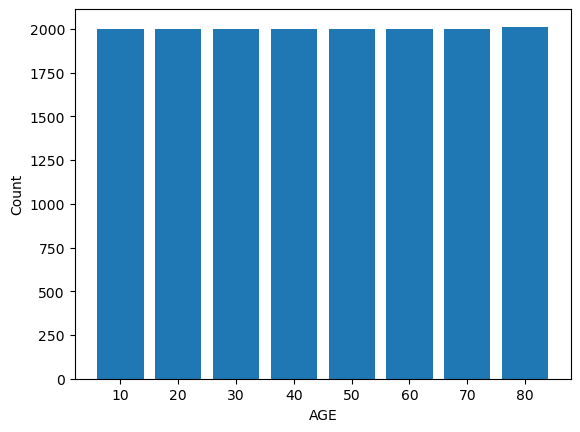

In [ ]:
plt.bar(["10","20","30","40","50","60","70","80"],c)
plt.xlabel("AGE")
plt.ylabel("Count")

In [ ]:
features_upscale

,Age,Pitch,Formant,Intensity,Duration,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,MFCC,Chroma,Zero Crossing Rate
0,20,1220.57290,592.665139,0.006928,5.832018,1827.311994,1891.320962,23.357881,0.008766,-27.616852,0.344941,0.091979
1,70,1613.80970,740.876205,0.015059,1.728027,2405.960497,1929.718353,22.093263,0.039348,-21.074581,0.390814,0.167148
2,30,1681.96020,775.933068,0.038097,4.224036,1853.162931,1379.076500,25.515921,0.001174,-20.890913,0.314568,0.120190
3,60,794.12585,619.218386,0.032311,5.376009,1844.103885,1897.411956,22.806667,0.022437,-17.845570,0.357120,0.082688
4,50,937.07153,848.577075,0.045045,3.720000,1910.189138,2246.842211,20.065554,0.032897,-3.291733,0.534488,0.081397
...,...,...,...,...,...,...,...,...,...,...,...,...
15986,80,1787.26570,744.607533,0.119779,2.760000,2765.258378,2480.642893,20.189394,0.108356,-8.910891,0.473363,0.189794
15987,80,1643.15980,670.100604,0.095103,3.528027,2311.792080,2383.565385,20.742630,0.073038,-7.316817,0.472368,0.147120
15988,80,1776.00040,766.670524,0.127540,4.896009,1933.274981,1534.453671,23.298110,0.004235,-13.307306,0.451208,0.134305
15989,80,1700.31840,731.870371,0.058489,2.976009,2652.745908,2381.926115,21.180454,0.083545,-21.135763,0.396447,0.164377


In [ ]:
features_upscale.to_csv("features_upscale.csv")

In [52]:
features = pd.read_csv("features_upscale.csv")
features

,Unnamed: 0,Age,Pitch,Formant,Intensity,Duration,Spectral Centroid,Spectral Bandwidth,Spectral Contrast,Spectral Flatness,MFCC,Chroma,Zero Crossing Rate
0,0,20,1220.57290,592.665139,0.006928,5.832018,1827.311994,1891.320962,23.357881,0.008766,-27.616852,0.344941,0.091979
1,1,70,1613.80970,740.876205,0.015059,1.728027,2405.960497,1929.718353,22.093263,0.039348,-21.074581,0.390814,0.167148
2,2,30,1681.96020,775.933068,0.038097,4.224036,1853.162931,1379.076500,25.515921,0.001174,-20.890913,0.314568,0.120190
3,3,60,794.12585,619.218386,0.032311,5.376009,1844.103885,1897.411956,22.806667,0.022437,-17.845570,0.357120,0.082688
4,4,50,937.07153,848.577075,0.045045,3.720000,1910.189138,2246.842211,20.065554,0.032897,-3.291733,0.534488,0.081397
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,15995,80,1787.26570,744.607533,0.119779,2.760000,2765.258378,2480.642893,20.189394,0.108356,-8.910891,0.473363,0.189794
15996,15996,80,1643.15980,670.100604,0.095103,3.528027,2311.792080,2383.565385,20.742630,0.073038,-7.316817,0.472368,0.147120
15997,15997,80,1776.00040,766.670524,0.127540,4.896009,1933.274981,1534.453671,23.298110,0.004235,-13.307306,0.451208,0.134305
15998,15998,80,1700.31840,731.870371,0.058489,2.976009,2652.745908,2381.926115,21.180454,0.083545,-21.135763,0.396447,0.164377


### TRAINING MODEL ON UPSCALLED DATA

In [55]:
# Choosing the Features with the Strongest Correlation with Age
data = pd.read_csv("features_upscale.csv")
data.head()

df = data[["Age","Pitch","Formant","Spectral Centroid","Zero Crossing Rate"]]
df.head()

,Age,Pitch,Formant,Spectral Centroid,Zero Crossing Rate
0,20,1220.57290,592.665139,1827.311994,0.091979
1,70,1613.80970,740.876205,2405.960497,0.167148
2,30,1681.96020,775.933068,1853.162931,0.120190
3,60,794.12585,619.218386,1844.103885,0.082688
4,50,937.07153,848.577075,1910.189138,0.081397


In [58]:
def loss_function(m1, m2, m3, m4 , c ,points):
    total_error = 0
    for i in range(len(points)):
        x1 = points.iloc[i]['Pitch']
        x2 = points.iloc[i]['Formant']
        x3 = points.iloc[i]['Spectral Centroid']
        x4 = points.iloc[i]['Zero Crossing Rate']
        y = points.iloc[i]['Age']
        prediction = (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4) + c
        total_error += (y - prediction) ** 2
    return total_error / float(len(points))

In [59]:
def gradient_descent(m1_now, m2_now, m3_now, m4_now, b_now, points, L):
    # Extracting features and target from the dataframe
    x1 = points['Pitch'].values
    x2 = points['Formant'].values
    x3 = points['Spectral Centroid'].values
    x4 = points['Zero Crossing Rate'].values
    y = points['Age'].values

    # Number of observations
    n = len(y)

    # Predicted ages
    pred = (m1_now * x1) + (m2_now * x2) + (m3_now * x3) + (m4_now * x4) + b_now

    # Calculating gradients
    error = y - pred
    m1_gradient = -(2/n) * np.dot(x1, error)
    m2_gradient = -(2/n) * np.dot(x2, error)
    m3_gradient = -(2/n) * np.dot(x3, error)
    m4_gradient = -(2/n) * np.dot(x4, error)
    b_gradient = -(2/n) * np.sum(error)

    # Updating parameters
    m1 = m1_now - L * m1_gradient
    m2 = m2_now - L * m2_gradient
    m3 = m3_now - L * m3_gradient
    m4 = m4_now - L * m4_gradient
    b = b_now - L * b_gradient

    return m1, m2, m3, m4, b

In [56]:
m1 = 0
m2 = 0
m3 = 0
m4 = 0
c = 0

# Set the learning rate and number of epochs for gradient descent
lr = 0.00000001
epochs = 1000

for i in range(epochs):
    m1, m2,m3,m4, c = gradient_descent(m1 ,m2 ,m3 ,m4 ,c ,data ,lr)
    if i % 100 == 0:
        error = loss_function(m1, m2,m3,m4, c, data)
        print("Epoch {0} - Error: {1}".format(i, error))
print()
print('M1: ',m1,'M2: ',m2,'M3: ',m3,'M4:',m4,'C:',c)

Epoch 0 - Error: 1907.6311628475228
Epoch 100 - Error: 540.6556937209851
Epoch 200 - Error: 535.8959673699103
Epoch 300 - Error: 532.5511550245269
Epoch 400 - Error: 530.1983184237477
Epoch 500 - Error: 528.541087398956
Epoch 600 - Error: 527.3717741637283
Epoch 700 - Error: 526.5448285215231
Epoch 800 - Error: 525.9582391030566
Epoch 900 - Error: 525.5405020030182

M1:  0.017640582499503763 M2:  0.008673800052818537 M3:  0.004496417938155472 M4: 3.6014187818246326e-07 C: 2.3055289857329554e-05


In [61]:
correct_predictions = 0
for i in range(len(test_features)):
    x1 = test_features.iloc[i]['Pitch']
    x2 = test_features.iloc[i]['Formant']
    x3 = test_features.iloc[i]['Intensity']
    x4 = test_features.iloc[i]['Duration']

    prediction = c + (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4)
    rounded_prediction = 10 * (prediction // 10)
    if rounded_prediction == test_features.iloc[i]['Age']:
        correct_predictions += 1
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction,'    ','Correct Prediction!')
    else:
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction)

Actual Age:  20.0      Predicted Age:  33.98997559587884
Actual Age:  20.0      Predicted Age:  27.91361470570034      Correct Prediction!
Actual Age:  20.0      Predicted Age:  25.659871734167545      Correct Prediction!
Actual Age:  20.0      Predicted Age:  41.7834372695152
Actual Age:  30.0      Predicted Age:  35.84038949590911      Correct Prediction!
Actual Age:  30.0      Predicted Age:  34.22901968604377      Correct Prediction!
Actual Age:  50.0      Predicted Age:  39.703027548889935
Actual Age:  20.0      Predicted Age:  40.37868806921227
Actual Age:  20.0      Predicted Age:  36.141657320664976
Actual Age:  20.0      Predicted Age:  31.65480989794353
Actual Age:  40.0      Predicted Age:  39.5663308670964
Actual Age:  20.0      Predicted Age:  32.724735313997975
Actual Age:  40.0      Predicted Age:  39.5236944696149
Actual Age:  50.0      Predicted Age:  34.846327447360416
Actual Age:  20.0      Predicted Age:  31.911619191080636
Actual Age:  30.0      Predicted Age:  42.

In [63]:
accuracy = correct_predictions / len(test_features) * 100
print("Accuracy of the model:", accuracy)

Accuracy of the model: 25.87548638132296


In [64]:
def loss_function(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c, points):
    total_error = 0
    for i in range(len(points)):
        x1 = points.iloc[i]['Pitch']
        x2 = points.iloc[i]['Formant']
        x3 = points.iloc[i]['Intensity']
        x4 = points.iloc[i]['Duration']
        x5 = points.iloc[i]['Spectral Centroid']
        x6 = points.iloc[i]['Spectral Bandwidth']
        x7 = points.iloc[i]['Spectral Contrast']
        x8 = points.iloc[i]['Spectral Flatness']
        x9 = points.iloc[i]['MFCC']
        x10 = points.iloc[i]['Chroma']
        x11 = points.iloc[i]['Zero Crossing Rate']
        y = points.iloc[i]['Age']
        # Update prediction equation to include all features
        prediction = (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4) + (m5 * x5) + (m6 * x6) + (m7 * x7) + (m8 * x8) + (m9 * x9) + (m10 * x10) + (m11 * x11) + c
        total_error += (y - prediction) ** 2
    return total_error / float(len(points))

In [65]:
def gradient_descent(m1_now, m2_now, m3_now, m4_now, m5_now, m6_now, m7_now, m8_now, m9_now, m10_now, m11_now, b_now, points, L):
    # Extracting features and target from the dataframe
    x1 = points['Pitch'].values
    x2 = points['Formant'].values
    x3 = points['Intensity'].values
    x4 = points['Duration'].values
    x5 = points['Spectral Centroid'].values
    x6 = points['Spectral Bandwidth'].values
    x7 = points['Spectral Contrast'].values
    x8 = points['Spectral Flatness'].values
    x9 = points['MFCC'].values
    x10 = points['Chroma'].values
    x11 = points['Zero Crossing Rate'].values
    y = points['Age'].values

    # Number of observations
    n = len(y)

    # Predicted ages
    pred = (m1_now * x1) + (m2_now * x2) + (m3_now * x3) + (m4_now * x4) + \
           (m5_now * x5) + (m6_now * x6) + (m7_now * x7) + (m8_now * x8) + \
           (m9_now * x9) + (m10_now * x10) + (m11_now * x11) + b_now

    # Calculating gradients
    error = y - pred
    m1_gradient = -(2/n) * np.dot(x1, error)
    m2_gradient = -(2/n) * np.dot(x2, error)
    m3_gradient = -(2/n) * np.dot(x3, error)
    m4_gradient = -(2/n) * np.dot(x4, error)
    m5_gradient = -(2/n) * np.dot(x5, error)
    m6_gradient = -(2/n) * np.dot(x6, error)
    m7_gradient = -(2/n) * np.dot(x7, error)
    m8_gradient = -(2/n) * np.dot(x8, error)
    m9_gradient = -(2/n) * np.dot(x9, error)
    m10_gradient = -(2/n) * np.dot(x10, error)
    m11_gradient = -(2/n) * np.dot(x11, error)
    b_gradient = -(2/n) * np.sum(error)

    # Updating parameters
    m1 = m1_now - L * m1_gradient
    m2 = m2_now - L * m2_gradient
    m3 = m3_now - L * m3_gradient
    m4 = m4_now - L * m4_gradient
    m5 = m5_now - L * m5_gradient
    m6 = m6_now - L * m6_gradient
    m7 = m7_now - L * m7_gradient
    m8 = m8_now - L * m8_gradient
    m9 = m9_now - L * m9_gradient
    m10 = m10_now - L * m10_gradient
    m11 = m11_now - L * m11_gradient
    b = b_now - L * b_gradient

    return m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, b

In [71]:
# Initializing coefficients for all 11 features and the intercept
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11 = [0] * 11  # All coefficients initialized to 0
c = 0  # Intercept

# Set the learning rate and number of epochs for gradient descent
lr = 0.00000001
epochs = 10000

for i in range(epochs):
    # Pass and update coefficients and intercept
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c = gradient_descent(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c, features, lr)
    if i % 1000 == 0:
        # Calculate error using updated coefficients and intercept
        error = loss_function(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, c, features)
        print(f"Epoch {i} - Error: {error}")

# Print the final coefficients and intercept
print(f'M1: {m1}, M2: {m2}, M3: {m3}, M4: {m4}, M5: {m5}, M6: {m6}, M7: {m7}, M8: {m8}, M9: {m9}, M10: {m10}, M11: {m11}, Intercept: {c}')


Epoch 0 - Error: 1631.0550668078681
Epoch 1000 - Error: 490.69902412502427
Epoch 2000 - Error: 485.5936094097765
Epoch 3000 - Error: 484.36107745595353
Epoch 4000 - Error: 483.81901057967593
Epoch 5000 - Error: 483.51297156677
Epoch 6000 - Error: 483.3282104810551
Epoch 7000 - Error: 483.2136312272388
Epoch 8000 - Error: 483.1406829691826
Epoch 9000 - Error: 483.0925480258817
M1: 0.02433089317378183, M2: -0.006730605974430062, M3: -6.586314572292315e-07, M4: 0.002209703730227465, M5: -0.013245171772753321, M6: 0.021465431866799767, M7: -6.852634068436566e-05, M8: 2.0287373220451662e-05, M9: -0.002603199742319115, M10: 2.6746379783423644e-05, M11: 1.9455384903652502e-05, Intercept: 1.0969179980700541e-05


In [67]:
correct_predictions = 0
for i in range(len(test_features)):
    # Extracting all feature values for each test point
    x1 = test_features.iloc[i]['Pitch']
    x2 = test_features.iloc[i]['Formant']
    x3 = test_features.iloc[i]['Intensity']
    x4 = test_features.iloc[i]['Duration']
    x5 = test_features.iloc[i]['Spectral Centroid']
    x6 = test_features.iloc[i]['Spectral Bandwidth']
    x7 = test_features.iloc[i]['Spectral Contrast']
    x8 = test_features.iloc[i]['Spectral Flatness']
    x9 = test_features.iloc[i]['MFCC']
    x10 = test_features.iloc[i]['Chroma']
    x11 = test_features.iloc[i]['Zero Crossing Rate']

    # Calculate the prediction using all coefficients
    prediction = c + (m1 * x1) + (m2 * x2) + (m3 * x3) + (m4 * x4) + (m5 * x5) + (m6 * x6) + (m7 * x7) + (m8 * x8) + (m9 * x9) + (m10 * x10) + (m11 * x11)

    # Rounding the prediction to the nearest age group in tens
    rounded_prediction = 10 * round(prediction / 10)

    # Checking if the rounded prediction matches the actual age
    if rounded_prediction == test_features.iloc[i]['Age']:
        correct_predictions += 1
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction,'    ','Correct Prediction!')
    else:
        print('Actual Age: ',test_features.iloc[i]['Age'],'    ','Predicted Age: ', prediction)

Actual Age:  20.0      Predicted Age:  46.91562976786274
Actual Age:  20.0      Predicted Age:  43.043841457017855
Actual Age:  20.0      Predicted Age:  36.78116247897919
Actual Age:  20.0      Predicted Age:  54.656963139053836
Actual Age:  30.0      Predicted Age:  51.501545788979236
Actual Age:  30.0      Predicted Age:  40.29731583517717
Actual Age:  50.0      Predicted Age:  47.670270934141676      Correct Prediction!
Actual Age:  20.0      Predicted Age:  49.61433705752099
Actual Age:  20.0      Predicted Age:  48.34247554509985
Actual Age:  20.0      Predicted Age:  44.29289485177422
Actual Age:  40.0      Predicted Age:  46.92460290119624
Actual Age:  20.0      Predicted Age:  43.10501692902764
Actual Age:  40.0      Predicted Age:  54.470289136480844
Actual Age:  50.0      Predicted Age:  48.70804108873307      Correct Prediction!
Actual Age:  20.0      Predicted Age:  48.050953464497255
Actual Age:  30.0      Predicted Age:  54.134327858919995
Actual Age:  50.0      Predicte

In [69]:
accuracy = correct_predictions / len(test_features) * 100
print("Accuracy of the model:", accuracy)

Accuracy of the model: 15.369649805447471
